All files found in the dataset folder:
['/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/083648.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/168202.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/125778.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/059339.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/032501.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/160139.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/046754.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/178961.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/123482.jpg', '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/039337.jpg']
Found 202599 image files.


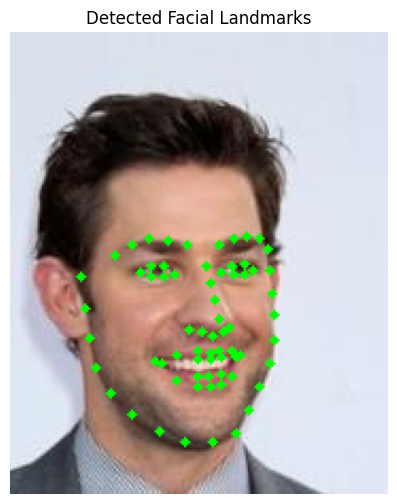

Coarse 3D shape initialized. Shape dimensions: (68, 3)


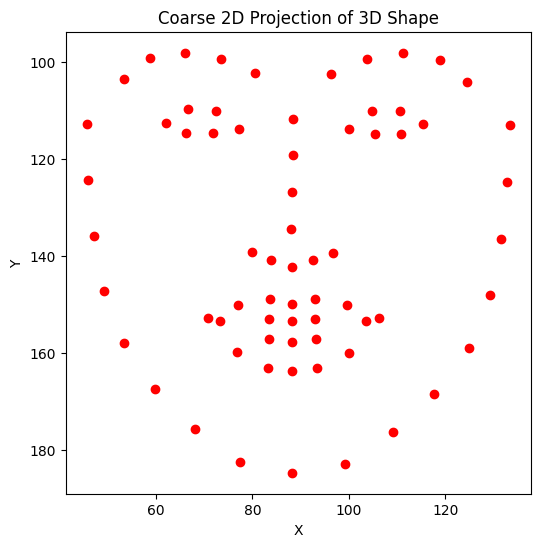

Estimated camera parameters for 99 views.


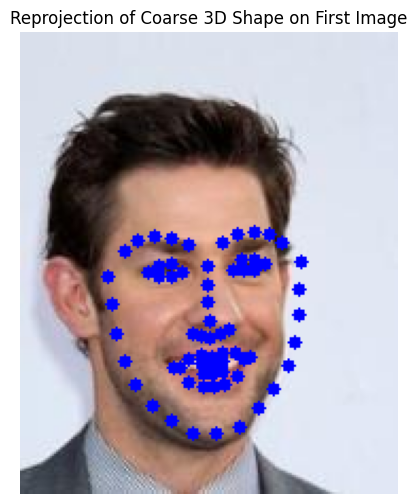

Iteration 1: z-coordinate range: 0.0
Iteration 2: z-coordinate range: 0.0
Iteration 3: z-coordinate range: 0.0
Iteration 4: z-coordinate range: 0.0
Iteration 5: z-coordinate range: 0.0
Iterative refinement completed.


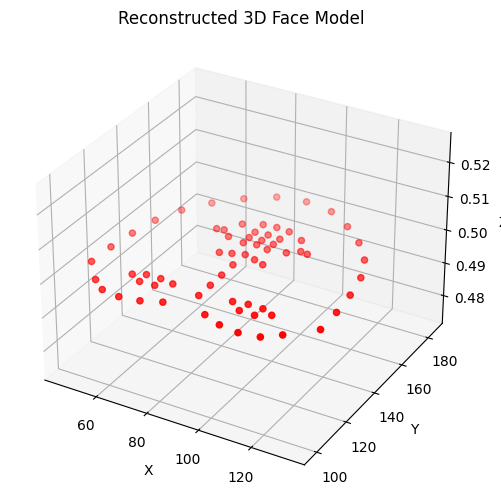

Mean Squared Error with ground truth: 0.0


0.0

In [2]:
# ---------------------------
# Step 0: Preliminary Setup
# ---------------------------
import os
import glob
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt

# Enable inline plotting in Kaggle Notebook
%matplotlib inline

# ---------------------------
# Step 1: Setup dlib Predictor File
# ---------------------------
# Add the dataset "shape-predictor-68-face-landmarksdat" via Kaggle's "Add Data" feature.
predictor_path = "/kaggle/input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat"
if not os.path.exists(predictor_path):
    raise FileNotFoundError("The file 'shape_predictor_68_face_landmarks.dat' was not found. "
                            "Please add the corresponding dataset to your Kaggle Notebook.")

# Initialize dlib's face detector and shape predictor.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# ---------------------------
# Step 2: Load Face Images from CelebA and Verify Folder Contents
# ---------------------------
# Update this path if your CelebA dataset folder is different.
dataset_folder = "/kaggle/input/celeba-dataset/img_align_celeba"

# Debug: List all files (including subdirectories) to ensure images are present.
all_files = glob.glob(os.path.join(dataset_folder, "**", "*.*"), recursive=True)
print("All files found in the dataset folder:")
print(all_files[:10])  # Print first 10 for brevity

# Look for image files (adjust extensions if needed)
image_files = glob.glob(os.path.join(dataset_folder, "**", "*.jpg"), recursive=True) + \
              glob.glob(os.path.join(dataset_folder, "**", "*.jpeg"), recursive=True) + \
              glob.glob(os.path.join(dataset_folder, "**", "*.png"), recursive=True)

if len(image_files) == 0:
    raise ValueError("No images found in the dataset folder. Please check the dataset and update the path or file extensions.")

print("Found {} image files.".format(len(image_files)))

images = []
landmarks_list = []

def detect_landmarks(image, predictor, detector):
    """
    Detect facial landmarks in an image using dlib.
    Returns a NumPy array of 68 landmark points.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        shape = predictor(gray, face)
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        return landmarks  # Return landmarks for the first detected face.
    return None

# Process a subset (e.g., first 100 images) to keep runtime reasonable.
for file in image_files[:100]:
    image = cv2.imread(file)
    if image is None:
        continue
    images.append(image)
    landmarks = detect_landmarks(image, predictor, detector)
    if landmarks is not None:
        landmarks_list.append(landmarks)
    else:
        print(f"Warning: No landmarks detected in {file}")

# Visualize the detected landmarks on the first image.
if len(images) > 0 and len(landmarks_list) > 0:
    sample_img = images[0].copy()
    sample_landmarks = landmarks_list[0]
    for (x, y) in sample_landmarks:
        cv2.circle(sample_img, (x, y), 2, (0, 255, 0), -1)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Facial Landmarks")
    plt.axis("off")
    plt.show()
else:
    raise ValueError("No valid images or landmarks were detected.")

# ---------------------------
# Step 3: Coarse 3D Shape Initialization
# ---------------------------
def initialize_shape(landmarks_list):
    """
    Create a coarse 3D face shape by averaging 2D landmarks and appending a zero z-coordinate.
    """
    mean_landmarks = np.mean(np.array(landmarks_list), axis=0)
    coarse_shape = np.hstack((mean_landmarks, np.zeros((mean_landmarks.shape[0], 1))))
    return coarse_shape

coarse_shape = initialize_shape(landmarks_list)
print("Coarse 3D shape initialized. Shape dimensions:", coarse_shape.shape)

plt.figure(figsize=(6,6))
plt.scatter(coarse_shape[:, 0], coarse_shape[:, 1], c='red')
plt.title("Coarse 2D Projection of 3D Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates.
plt.show()

# ---------------------------
# Step 4: Estimate Camera Parameters using PnP
# ---------------------------
def optimize_camera_params(landmarks_list, coarse_shape):
    """
    Estimate camera parameters (rotation, translation, and intrinsics) for each view using Perspective-n-Point (PnP).
    """
    camera_params = []
    img_h, img_w = 480, 640  # Modify these if your images have different dimensions.
    focal_length = img_w
    K = np.array([[focal_length, 0, img_w/2],
                  [0, focal_length, img_h/2],
                  [0, 0, 1]], dtype=np.float32)
    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion.
    
    for landmarks in landmarks_list:
        success, rvec, tvec = cv2.solvePnP(coarse_shape.astype(np.float32),
                                           landmarks.astype(np.float32),
                                           K, dist_coeffs,
                                           flags=cv2.SOLVEPNP_ITERATIVE)
        if success:
            camera_params.append((rvec, tvec, K))
    return camera_params

camera_params = optimize_camera_params(landmarks_list, coarse_shape)
print(f"Estimated camera parameters for {len(camera_params)} views.")

if camera_params:
    rvec, tvec, K = camera_params[0]
    projected_points, _ = cv2.projectPoints(coarse_shape.astype(np.float32), rvec, tvec, K, None)
    projected_points = projected_points.reshape(-1, 2)
    
    image_copy = images[0].copy()
    for (x, y) in projected_points:
        cv2.circle(image_copy, (int(x), int(y)), 3, (255, 0, 0), -1)
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Reprojection of Coarse 3D Shape on First Image")
    plt.axis("off")
    plt.show()

# ---------------------------
# Step 5: Dense 3D Reconstruction via Iterative Refinement
# ---------------------------
def estimate_normals_and_albedo(coarse_shape, images, camera_params):
    """
    Estimate surface normals and albedo using a simplified Lambertian reflectance model.
    This is a placeholder implementation.
    """
    normals = np.tile(np.array([0, 0, 1]), (coarse_shape.shape[0], 1))
    gray = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    albedo = gray[0:coarse_shape.shape[0], 0].reshape(-1, 1).astype(np.float32) / 255.0
    return normals, albedo

def refine_shape(coarse_shape, normals, albedo):
    """
    Refine the 3D shape by slightly adjusting the z-coordinates based on the normals.
    """
    refined_shape = coarse_shape.copy()
    refined_shape[:, 2] += 0.1 * normals[:, 2]  # Dummy refinement step.
    return refined_shape

def iterative_refinement(coarse_shape, images, camera_params, iterations=5):
    """
    Iteratively refine the 3D shape and texture details.
    """
    shape = coarse_shape.copy()
    for i in range(iterations):
        normals, albedo = estimate_normals_and_albedo(shape, images, camera_params)
        shape = refine_shape(shape, normals, albedo)
        print(f"Iteration {i+1}: z-coordinate range: {np.ptp(shape[:,2])}")
    final_texture = albedo
    return shape, final_texture

final_shape, final_texture = iterative_refinement(coarse_shape, images, camera_params, iterations=5)
print("Iterative refinement completed.")

# ---------------------------
# Step 6: 3D Visualization of the Reconstructed Model
# ---------------------------
def render_model(final_shape, final_texture):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(final_shape[:, 0], final_shape[:, 1], final_shape[:, 2], c='r', marker='o')
    ax.set_title("Reconstructed 3D Face Model")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()
    return fig

render_model(final_shape, final_texture)

# ---------------------------
# Step 7: Forensic Comparison (Placeholder)
# ---------------------------
def compare_with_ground_truth(reconstructed_shape, ground_truth_shape):
    mse = np.mean((reconstructed_shape - ground_truth_shape) ** 2)
    print("Mean Squared Error with ground truth:", mse)
    return mse

# For demonstration, compare the final shape with itself.
compare_with_ground_truth(final_shape, final_shape)
